# Recurrent Neural Network (RNN)

This module demonstrates the implementation of a simple RNN using PyTorch. It generates synthetic sequential data, trains the RNN model, and evaluates its predictions.

Authors: Pierre Lepetit and Rachid El Montassir

In [2]:
from PIL import Image
import os
if os.path.exists("rnn.png"):
  ! git clone https://github.com/relmonta/ml-student.git
  ! mv ml-student/TP4/*.png .
  ! mv ml-student/TP4/*.csv .

## What are RNNs?

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to process sequential data. Unlike traditional feedforward neural networks, which process the entire input independently, RNNs maintain a hidden state that captures information about the input seen so far. This hidden state is updated at each time step, allowing RNNs to retain information about the context of the sequence.

RNNs are well-suited for tasks involving sequences, such as time series analysis, natural language processing, speech recognition, and more. They process inputs one step at a time, maintaining an internal state that captures information about the sequence.

RNNs share the same set of parameters across all time steps. This parameter sharing allows the network to learn and generalize patterns from one part of the sequence to another. It is particularly useful when dealing with sequences of varying lengths.

## Structure of an RNN block:

The basic structure of an RNN block involves the following components:

#### Input:

- **X(t):** Input at time step t.

#### Hidden State:

- **H(t):** Hidden state at time step t.
- **H(t-1):** Hidden state from the previous time step.

The hidden state of an RNN block serves as its memory, allowing it to capture information from previous time steps and use it to influence future predictions.
#### Output:

- **H(t):** The module implemented in PyTorch considers the hidden state as the output at time step t, and also computed as follows :

$$H(t) = tanh(W_{hh} \cdot H(t-1) + W_{xh} \cdot X(t) + b_h)$$

where:
- $(W_{hh})$ and $( W_{xh} )$ are weight matrices.
- $(b_h)$ and $( b_y )$ are bias vectors.


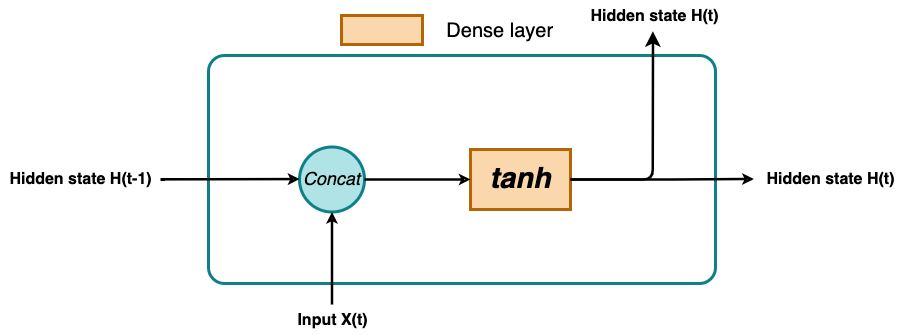

In [6]:
Image.open("rnn.png")

**Note:** There are other implementations depending on the task and input features, and the output can be different from the hidden state.
## RNN network:

- **X:** The input sequence.
- **H:** The concatenated hidden states.


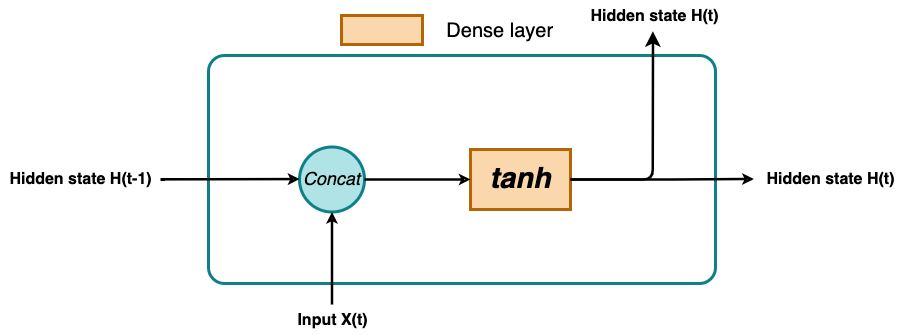

In [5]:
Image.open("rnn.png")

## Challenges:

While RNNs have proven effective for many sequence-based tasks, they suffer from challenges such as vanishing gradients and difficulties in capturing long-term dependencies. To address these issues, more advanced RNN architectures, such as Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), have been developed.

In summary, Recurrent Neural Networks are powerful for modelling sequential data. Their ability to capture temporal dependencies makes them indispensable in applications ranging from natural language processing to time series prediction.

In [11]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generating synthetic sequential data

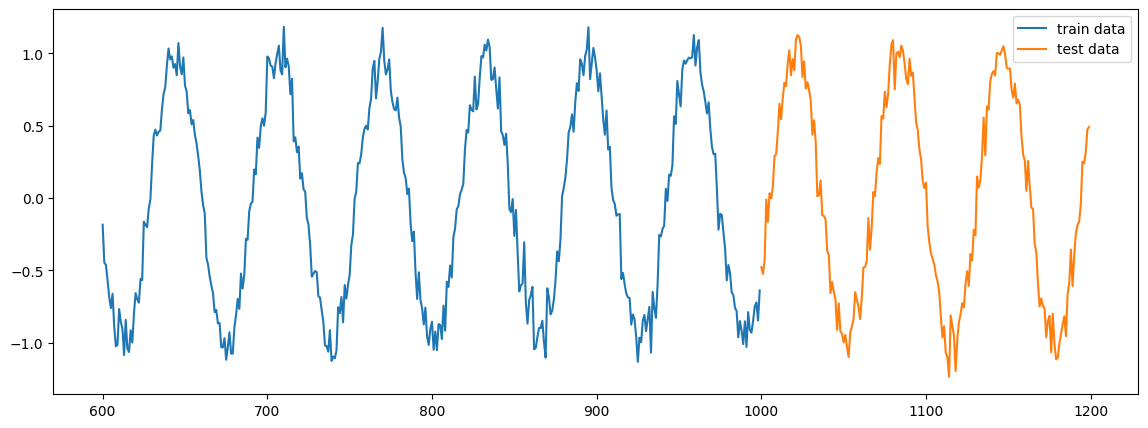

In [14]:
noise_scale = 1e-1
data = np.sin(np.arange(0, 200, 0.1)) + np.random.normal(0, noise_scale, 2000)
split_at = 1000
train_data = data[:split_at]
test_data = data[split_at:]

start_plot = 600
stop_plot = 1200
plt.figure(figsize=(14,5))
plt.plot(range(start_plot, split_at),data[start_plot:split_at],label="train data")
plt.plot(range(split_at, stop_plot),test_data[:stop_plot-split_at],label="test data")
plt.legend()
plt.show()
# Converting data to PyTorch tensor
train_data = torch.FloatTensor(train_data).view(-1, 1)
test_data = torch.FloatTensor(test_data).view(-1, 1)

# Dataset

In [15]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, data, input_sequence_len):
        self.data = data
        self.input_sequence_len = input_sequence_len

    def __len__(self):
        return len(self.data) - self.input_sequence_len

    def __getitem__(self, start_idx):
        # Extracting a sequence of data
        sequence = self.data[start_idx:start_idx + self.input_sequence_len]
        # Target is the next value in the sequence
        target = self.data[start_idx + self.input_sequence_len]
        return {'sequence': sequence, 'target': target}

# Simple Fully Connected network

**Exercise 1**: We start by implement a simple fully connected model.

Implement a fully connected model using an input layer and a hidden layer.

In [16]:
class SimpleFC(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFC, self).__init__()
        ### BEGIN SOLUTION
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        ### END SOLUTION

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc(out[:, -1, :])
        return out

# Training

**Exercise 2**: Implement the train loop (use GPU).

In [17]:
from tqdm import tqdm
import time
def train(model, dataloader, learning_rate=0.001, epochs=100, device=device):
    """
    Trains a Recurrent model.

    Args:
    - model (nn.Module): model to be trained.
    - dataloader (DataLoader): DataLoader for the training data.
    - learning_rate (float): Learning rate, default to 1e-3.
    - epochs (int): Number of training epochs.
    - device (str): Device to use ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - model (nn.Module): Trained model.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    since = time.time()
    model = model.to(device)
    for epoch in tqdm(range(epochs)):
        # for batch in dataloader:
        #     ....
        ### BEGIN SOLUTION
        for batch in dataloader:
            input = batch['sequence'].to(device)
            target = batch['target'].to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
        ### END SOLUTION
    print(f"\nTotal time :{(time.time()-since):.1f} s")
    return model

In [18]:
input_sequence_len = 20

dataset = TimeSeriesDataset(train_data, input_sequence_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

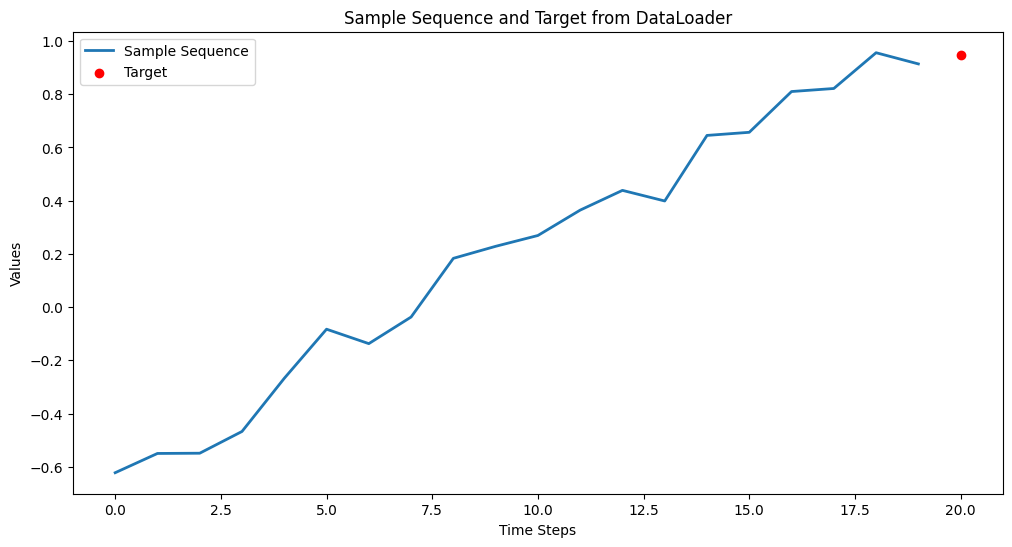

In [19]:
# Plot a sample sequence and target from the DataLoader
sample_batch = next(iter(dataloader))
sample_sequence = sample_batch['sequence'][0].numpy()
sample_target = sample_batch['target'][0].numpy()

plt.figure(figsize=(12, 6))
plt.plot(sample_sequence, linewidth=2, label='Sample Sequence')
plt.scatter(input_sequence_len, sample_target, color='red', label='Target')
plt.legend()
plt.title('Sample Sequence and Target from DataLoader')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [32]:
input_size = 1
hidden_size = 512
output_size = 1
epochs = 500

fc_model = SimpleFC(input_size, hidden_size, output_size)

trained_fc_model = train(fc_model, dataloader, learning_rate=0.01, epochs=epochs)

100%|██████████| 500/500 [00:15<00:00, 32.96it/s]


Total time :15.2 s


# Evaluating the model

In [33]:
def evaluate_model(model, data, input_sequence_len, future_steps, device=device):
    """
    Evaluates the given model by making predictions for future time steps.

    Args:
    - model (nn.Module): Trained model to be evaluated.
    - data (torch.Tensor): Input data for evaluation.
    - input_sequence_len (int): Length of the input sequence.
    - future_steps (int): Number of future time steps to predict.
    - device (str): Device to use ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - predictions (torch.Tensor): Predicted values for future time steps.
    - errors (torch.Tensor): Errors for each time step.
    """
    with torch.no_grad():
        model.eval()
        # Generating a sequence for evaluation
        eval_sequence = data[-input_sequence_len:].view(1, -1, 1).to(device)
        # Making predictions for the future time steps
        predictions = eval_sequence.clone().squeeze(-1)
        for i in range(future_steps):
            pred = model(eval_sequence[:, i:, :])
            eval_sequence = torch.cat([eval_sequence, pred.unsqueeze(1)], dim=1)
            predictions = torch.cat([predictions, pred], dim=1)

        predictions = predictions.cpu()
        errors = (predictions[:,input_sequence_len:].view(-1) - test_data[:future_steps].view(-1))**2

    return predictions[:,input_sequence_len:], errors.numpy()

In [34]:
future_steps = 200
fc_predictions, rnn_errors = evaluate_model(trained_fc_model, train_data, input_sequence_len, future_steps)

In [35]:
# Plotting the results
def plot_predictions(predictions,title):
    plt.figure(figsize=(14, 5))
    plt.plot(np.arange(start_plot,len(train_data)), train_data[start_plot:].numpy(), 'g--',label='Training data',linewidth=2)
    plt.plot(np.arange(len(train_data) - input_sequence_len, len(train_data)), train_data[-input_sequence_len:].numpy(),'r--',label='Input sequence',linewidth=2)
    plt.plot(np.arange(len(train_data), len(train_data) + future_steps), test_data[:future_steps].view(-1).numpy(),'--', label='Test sequence',linewidth=2)
    plt.plot(np.arange(len(train_data), len(train_data) + future_steps), predictions.view(-1).numpy(),'orange', label='Predicted sequence',linewidth=2)
    plt.legend()
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

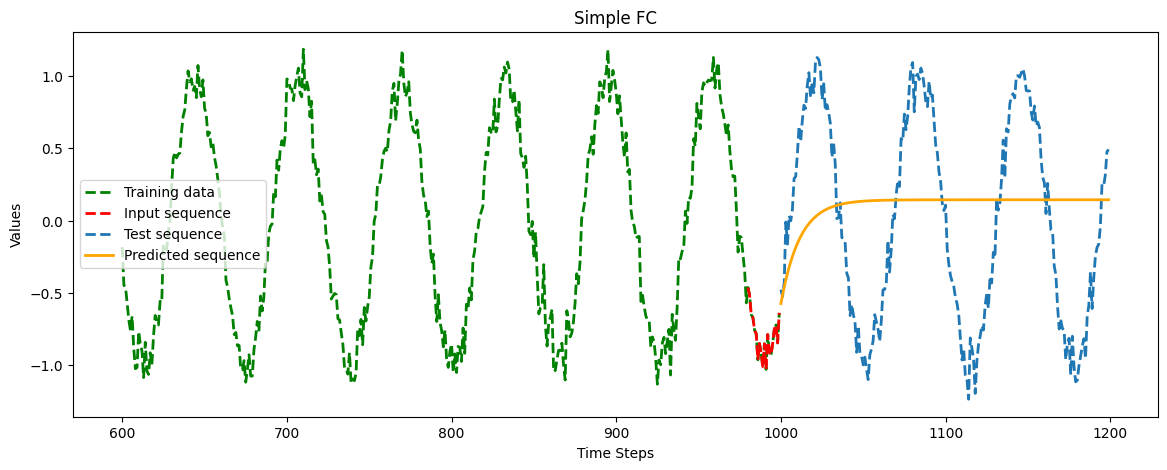

In [36]:
plot_predictions(fc_predictions,'Simple FC')

# Setting up the RNN model

**Exercise 3**: Replace the dense layer used in the last model by an RNN layer.


In [37]:
class SimpleRNN(nn.Module):
    """
    Simple Recurrent Neural Network (RNN) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the RNN layer.
    - output_size (int): Number of output features.

    Attributes:
    - rnn (nn.RNN): RNN layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        ### BEGIN SOLUTION
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        ### END SOLUTION
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [38]:
input_size = 1
hidden_size = 32
output_size = 1
epochs = 500

rnn_model = SimpleRNN(input_size, hidden_size, output_size)

trained_rnn_model = train(rnn_model, dataloader, learning_rate=0.01, epochs=epochs)

100%|██████████| 500/500 [00:19<00:00, 25.72it/s]


Total time :19.9 s


In [39]:
future_steps = 200
rnn_predictions, rnn_errors = evaluate_model(trained_rnn_model, train_data, input_sequence_len, future_steps)

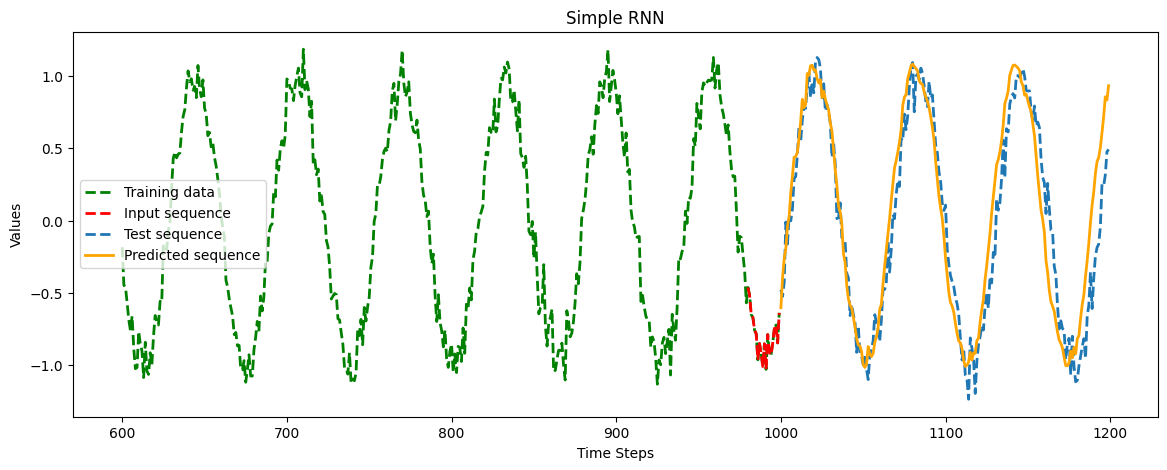

In [40]:
plot_predictions(rnn_predictions,'Simple RNN')

# Long Short-Term Memory (LSTM)
In RNNs, the hidden state acts as a memory, but it tends to lose information over time due to the recurrent nature of the network.
LSTMs introduce a memory cell that can store and retrieve information over long periods. The cell state allows LSTMs to maintain a more stable memory of past inputs.

Standard RNNs suffer from the vanishing and exploding gradient problems, which make it difficult for them to capture and propagate information across long sequences. As the sequence length increases, RNNs struggle to remember information from earlier time steps.
LSTMs were specifically designed to address the vanishing gradient problem. The architecture uses memory cell and gating mechanisms that allow it to selectively remember or forget information over long sequences. This enables LSTMs to capture dependencies over extended time horizons compared to RNNs.

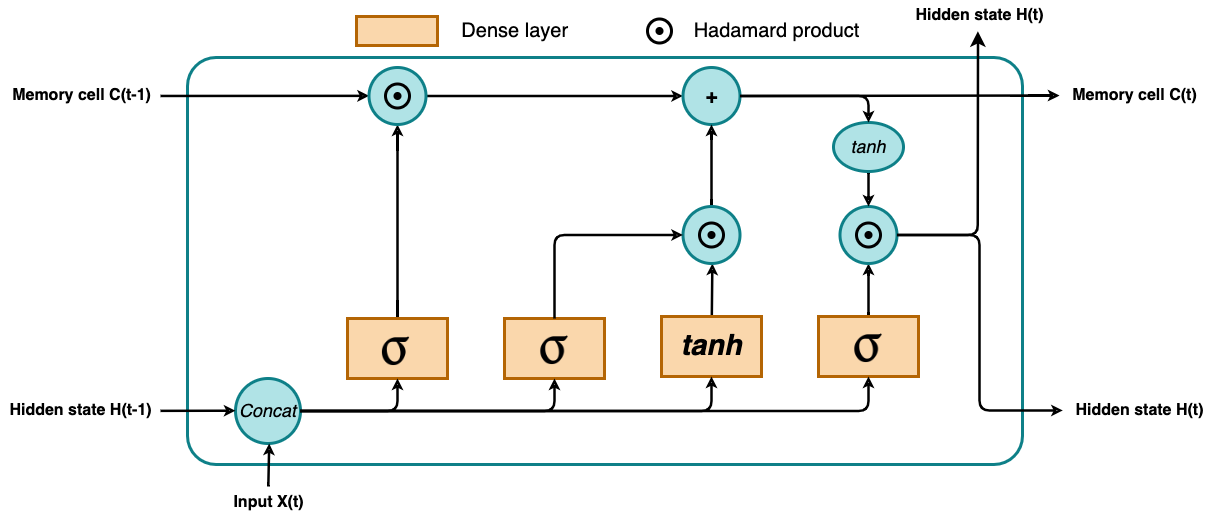

In [8]:
Image.open("lstm.png")

Here, we introduce LSTM, which is a type of recurrent neural network architecture designed to overcome the vanishing gradient problem and capture long-term dependencies in data.

**Exercise 4**: Replace the RNN layer by an LSTM layer.

In [41]:
class LSTMModel(nn.Module):
    """
    Long Short-Term Memory (LSTM) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the LSTM layer.
    - output_size (int): Number of output features.

    Attributes:
    - lstm (nn.LSTM): LSTM layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        ### BEGIN SOLUTION
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        ### END SOLUTION
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [42]:
input_size = 1
hidden_size = 32
output_size = 1

lstm_model = LSTMModel(input_size, hidden_size, output_size)

trained_lstm_model = train(lstm_model, dataloader, learning_rate=0.01, epochs=epochs)

100%|██████████| 500/500 [00:19<00:00, 26.13it/s]


Total time :19.1 s


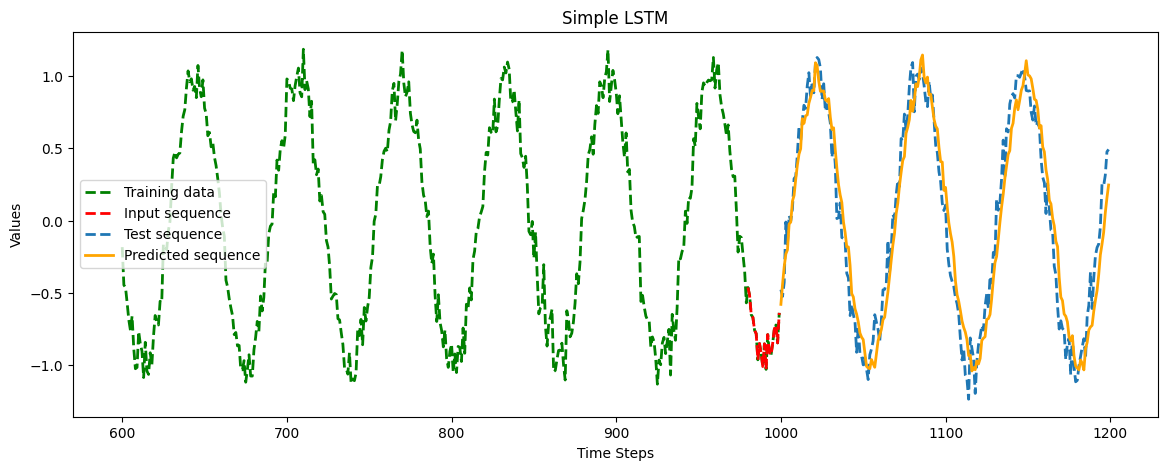

In [43]:
lstm_predictions, lstm_errors = evaluate_model(trained_lstm_model, train_data, input_sequence_len, future_steps)
plot_predictions(lstm_predictions,'Simple LSTM')

**Exercise 5**: Use multiple LSTM layer (use `num_layers` option)

In [50]:
class ImprovedLSTMModel(nn.Module):
    """
    Improved Long Short-Term Memory (LSTM) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the LSTM layer.
    - output_size (int): Number of output features.
    - num_layers (int, optional): Number of LSTM layers. Default is 1.

    Attributes:
    - lstm (nn.LSTM): LSTM layer.
    - relu (nn.ReLU): ReLU activation function.
    - dropout (nn.Dropout): Dropout layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ImprovedLSTMModel, self).__init__()
        ### BEGIN SOLUTION
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        ### END SOLUTION
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        out, _ = self.lstm(x)
        out = self.relu(out)
        out = self.fc(out[:, -1, :])
        return out

In [51]:
input_size = 1
hidden_size = 32
output_size = 1
num_layers=5

lstm_model_2 = ImprovedLSTMModel(input_size, hidden_size, output_size,num_layers=num_layers)

trained_lstm_model_2 = train(lstm_model_2, dataloader, learning_rate=0.01, epochs=epochs)

100%|██████████| 500/500 [00:25<00:00, 19.96it/s]



Total time :25.1 s


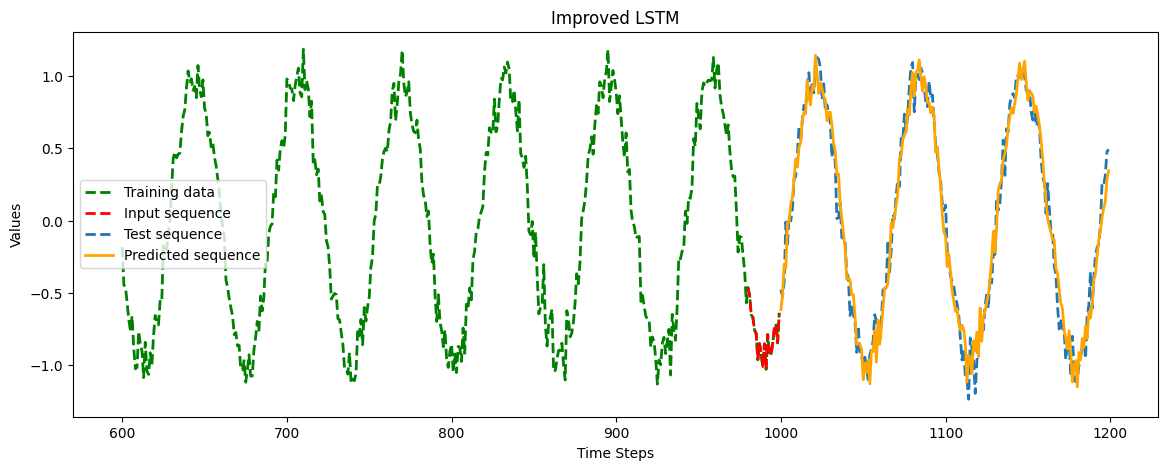

In [52]:
lstm_predictions_2, lstm_errors_2 = evaluate_model(trained_lstm_model_2, train_data, input_sequence_len, future_steps)
plot_predictions(lstm_predictions_2,'Improved LSTM')

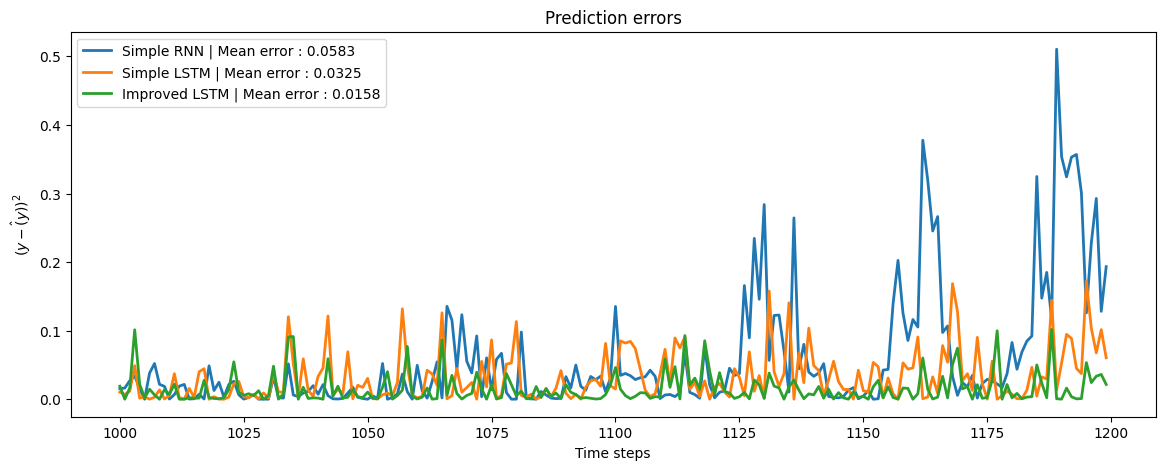

In [53]:
# Prediction errors comparison
plt.figure(figsize=(14,5))
plt.plot(range(len(train_data),len(train_data)+future_steps),rnn_errors,
         label=f"Simple RNN | Mean error : {np.mean(rnn_errors):.4f}",linewidth=2)
plt.plot(range(len(train_data),len(train_data)+future_steps),lstm_errors,
         label=f"Simple LSTM | Mean error : {np.mean(lstm_errors):.4f}",linewidth=2)
plt.plot(range(len(train_data),len(train_data)+future_steps),lstm_errors_2,
         label=f"Improved LSTM | Mean error : {np.mean(lstm_errors_2):.4f}",linewidth=2)
plt.legend()
plt.title("Prediction errors")
plt.xlabel("Time steps")
plt.ylabel("$(y-\hat(y))^2$")
plt.show()

# Training using real temperature data

In [54]:
import pandas as pd
file_path = "/content/temperatures.csv"
df = pd.read_csv(file_path, header=None, sep=" ")
df = df.rename(columns={df.columns[0]: 'Date',df.columns[-1]: 'Temperature'})

FileNotFoundError: ignored

In [55]:
real_data = np.array(df.Temperature)-273.15 # − 273.15 to go from K to °C
plt.figure(figsize=(14,5))
plt.plot(real_data)
plt.xlabel("Time steps (in hours)")
plt.ylabel("Temperature (°C)")
plt.show()

NameError: ignored

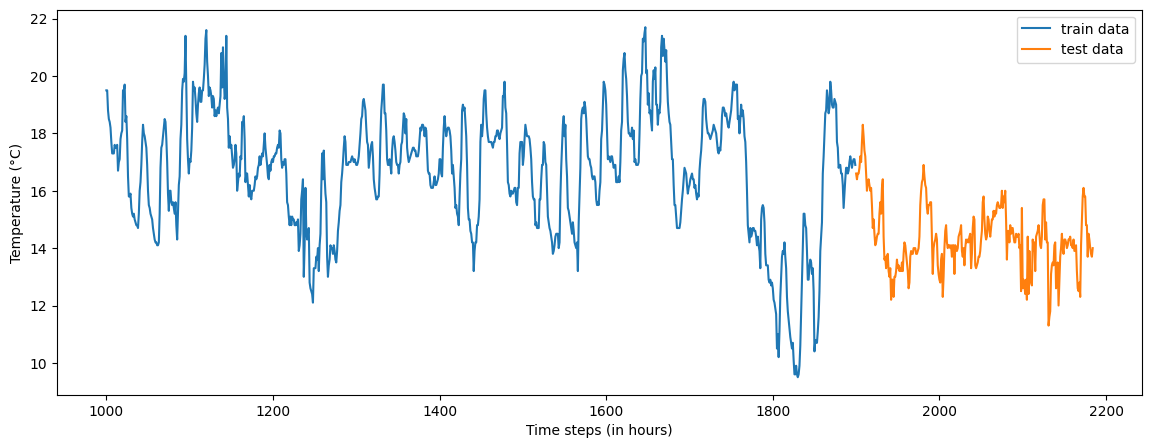

In [ ]:
split_at = 1900
train_data = real_data[:split_at]
test_data = real_data[split_at:]

start_plot = 1000
stop_plot = len(real_data)
plt.figure(figsize=(14,5))
plt.plot(range(start_plot, split_at),real_data[start_plot:split_at],label="train data")
plt.plot(range(split_at, stop_plot),test_data[:stop_plot-split_at],label="test data")
plt.xlabel("Time steps (in hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()
# Converting data to PyTorch tensor
train_data = torch.FloatTensor(train_data).view(-1, 1)
test_data = torch.FloatTensor(test_data).view(-1, 1)

**Exercise 6**: Implement a model to predict the temperature over the 24 hours using the last 48 hours.

In [ ]:
input_size = 1
hidden_size = 32
output_size = 1

input_sequence_len = 48 # Take the last 72 hours as an input sequence
### BEGIN SOLUTION
dataset = TimeSeriesDataset(train_data, input_sequence_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

lstm_model = LSTMModel(input_size, hidden_size, output_size)

epochs = 500
trained_lstm_model = train(lstm_model, dataloader, learning_rate=0.01, epochs=epochs)
### END SOLUTION

100%|██████████| 500/500 [00:34<00:00, 14.31it/s]


Total time :35.0 s


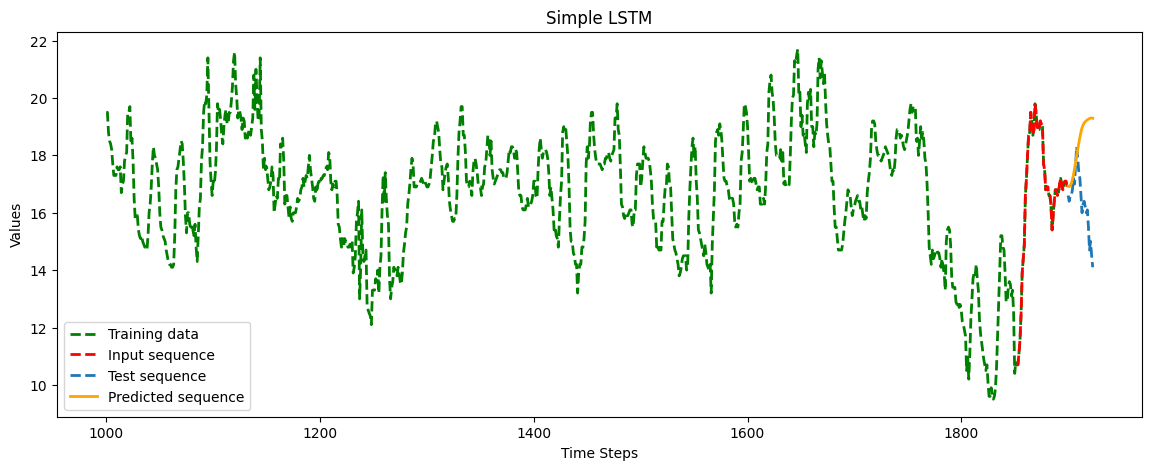

In [ ]:
future_steps = 24 # A prediction over the next 24 hours
### BEGIN SOLUTION
lstm_predictions, lstm_errors = evaluate_model(trained_lstm_model, train_data, input_sequence_len, future_steps)
plot_predictions(lstm_predictions,'Simple LSTM')
### END SOLUTION

## Vanishing gradients
Vanishing gradients is a problem that can occur during the training of deep neural networks, particularly in recurrent neural networks (RNNs) and networks with many layers. It refers to the situation where the gradients of the loss function with respect to the parameters become extremely small, causing the weights to stop updating or updating very slowly during the training process.

The issue arises during the backpropagation algorithm, which is used to update the weights of the neural network based on the computed gradients. When the gradients become very small, the updates to the weights also become very small, and as a result, the weights may not change significantly, or they may converge to values where the network does not learn effectively.

Let's consider a simple feedforward neural network with multiple layers.

In a neural network, the weights are updated using the gradient descent optimization algorithm. The weights are adjusted in the opposite direction of the gradient of the loss function with respect to the weights. Mathematically, this can be expressed as:

$$ W_{ij}^{(l)} = W_{ij}^{(l)} - \alpha \frac{\partial L}{\partial W_{ij}^{(l)}} $$

where:
- $( W_{ij}^{(l)} )$ is the weight connecting neuron $(i)$ in layer $(l-1)$ to neuron $(j)$ in layer $(l)$.
- $( \alpha )$ is the learning rate.
- $( L )$ is the loss function.

The key factor that leads to vanishing gradients is the chain rule of calculus applied during backpropagation. The gradient of the loss with respect to the weights in layer $(l)$ is computed by recursively applying the chain rule:

$$ \frac{\partial L}{\partial W_{ij}^{(l)}} = \frac{\partial L}{\partial a_j^{(l)}} \cdot \frac{\partial a_j^{(l)}}{\partial W_{ij}^{(l)}} $$

where:
- $( a_j^{(l)} )$ is the input to neuron $(j)$ in layer $(l)$.

The vanishing gradient problem arises when the terms $( \frac{\partial L}{\partial a_j^{(l)}} )$ and $( \frac{\partial a_j^{(l)}}{\partial W_{ij}^{(l)}} )$ become very small for deep layers during the multiplication process.


Sometimes, this issue occurs with certain activation functions, such as the sigmoid or hyperbolic tangent (tanh), have saturating regions where the gradients become very small. In these regions, the derivatives of the functions approach zero, causing the gradients to vanish.
This happens due to the use of activation functions that saturate, such as the sigmoid or hyperbolic tangent (tanh).

Let's consider the sigmoid activation function as an example:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

The derivative of the sigmoid function is:

$$ \sigma'(x) = \sigma(x) \cdot (1 - \sigma(x)) $$

In the context of the neural network formulation, if $( a_j^{(l)} )$ is large (positive or negative), the sigmoid function saturates, and its derivative becomes very close to zero. This small derivative gets multiplied with other small derivatives as we move backward through the layers during backpropagation, causing the overall gradient to vanish.